# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms, models
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from workspace_utils import active_session
from PIL import Image
import json
import argparse
%matplotlib inline





In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# DONE: Define your transforms for the training, validation, and testing sets
Data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                                transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.485, 0.456, 0.406),
                                                                     (0.229, 0.224, 0.225))]), 
                   
                   'valid': transforms.Compose([transforms.Resize(255),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.485, 0.456, 0.406),
                                                                     (0.229, 0.224, 0.225))]), 
                   
                   'test': transforms.Compose([transforms.Resize(255),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.485, 0.456, 0.406),
                                                                    (0.229, 0.224, 0.225))])}


# DONE: Load the datasets with ImageFolder
image_datasets = {'train': datasets.ImageFolder(train_dir, transform=Data_transforms['train']),
                  
                  'valid': datasets.ImageFolder(valid_dir, transform=Data_transforms['valid']),
                  
                  'test': datasets.ImageFolder(test_dir, transform=Data_transforms['test'])}


# DONE: Using the image datasets and the trainforms, define the dataloaders


trainloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True)

validloader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32, shuffle=False)

testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False)


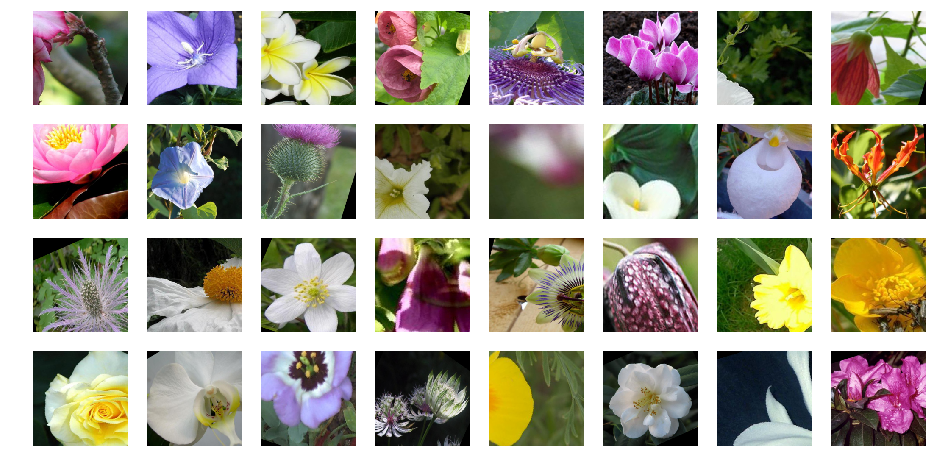

In [4]:
# Select a batch of images from the dataset
images, _ = next(iter(trainloader))

# Unnormalize the images
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
images = images.numpy().transpose(0, 2, 3, 1)
for i in range(images.shape[-1]):
    images[:, :, :, i] = images[:, :, :, i] * std[i] + mean[i]

# Plot the images
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(np.clip(images[i], 0, 1))
    ax.axis('off')

plt.show()

(224, 224, 3)


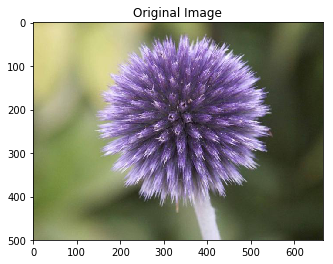

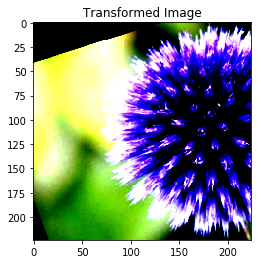

In [21]:
# Load an image from the file system
img = Image.open("flowers/train/10/image_07086.jpg")
img_tensor = torch.from_numpy(np.array(img))

# Apply the transformations to the image
transformed_img = Data_transforms['train'](img)
transformed_img = transformed_img.numpy().transpose((1, 2, 0))

print(np.shape(transformed_img))
# Convert the tensor to a numpy array and denormalize the image
img_tensor = torch.from_numpy(np.array(img))
transformed_img = np.clip(transformed_img, 0, 1)


# Plot the original and transformed images
plt.figure()
plt.title('Original Image')
plt.imshow(img)

# Plot the transformed image
plt.figure()
plt.title('Transformed Image')
plt.imshow(transformed_img)

plt.show()

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [7]:
# Import the vgg16 model from the `models` module of the torchvision library
my_model = models.vgg16(pretrained=True)

# Print the details of the vgg16 model
print(my_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
# Freeze the model's parameters so that they don't get updated during training
for param in my_model.parameters():
    param.requiresGrad = False
    

    

In [9]:
# Define a classifier as a Sequential model
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 1024)),
                                        ('relu1', nn.ReLU()),
                                        ('dropout1', nn.Dropout(p=0.5)), 
                                        ('fc2', nn.Linear(1024, 102)),
                                        ('output', nn.LogSoftmax(dim=1))]))

# Replace the model's classifier with the newly defined classifier
my_model.classifier = classifier



In [10]:
# Determine the device to run the model on (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the specified device
my_model.to(device)

# Define the loss function as negative log likelihood loss
criterion = nn.NLLLoss()

# Define the optimizer as Adam optimizer with learning rate 0.001
optimizer = optim.Adam(my_model.classifier.parameters(), lr=0.001)





In [11]:
# Define the number of epochs
epochs = 3

# Initialize the step count and running loss
step = 0
run_loss = 0

# Define the frequency of printing the loss and accuracy during training
print_for_every = 10

# Loop through each epoch
for any_e in range(epochs):
    
    # Loop through each training data and label
    for train_in, train_lab in trainloader:
        
        # Increment the step count
        step += 1
        
        # Move the training data and label to the device
        train_in, train_lab = train_in.to(device), train_lab.to(device)
        
        # Zero out the gradients
        optimizer.zero_grad() 
        
        # Forward pass
        log_out = my_model.forward(train_in)
        
        # Compute the loss
        loss = criterion(log_out, train_lab)
        
        # Backward pass
        loss.backward() 
        
        # Optimize the parameters
        optimizer.step() 
        
        # Accumulate the loss
        run_loss += loss.item() 
            
        # Print the loss and accuracy for validation data at the defined frequency
        if (step % print_for_every == 0): 
            loss_in_valid = 0
            accuracy_in_valid = 0
            
            # Set the model to evaluation mode
            my_model.eval() 
            
            # Turn off gradients
            with torch.no_grad(): 
                
                # Loop through each validation data and label
                for val_in, val_lab in validloader:
                    
                    # Move the validation data and label to the device
                    val_in, val_lab = val_in.to(device), val_lab.to(device)
                    
                    # Forward pass
                    log_out = my_model.forward(val_in)
                    
                    # Compute the loss for this batch of validation data
                    loss_in_batch = criterion(log_out, val_lab)
                    
                    # Accumulate the loss
                    loss_in_valid += loss_in_batch.item()
                    
                    # Compute the probability for each class
                    prob = torch.exp(log_out)
                    
                    # Find the top predicted class and its corresponding probability
                    top_predicted , top_class = prob.topk(1, dim=1)
                    
                    # Determine if the predicted class is equal to the true label
                    equals = top_class == val_lab.view(*top_class.shape) 
                    
                    # Accumulate the accuracy
                    accuracy_in_valid += torch.mean(equals.type(torch.FloatTensor)).item()
                        
            # Print the loss and accuracy for this step
            print(f"Epoch==> {any_e+1}/{epochs}.. "f"Loss_In_Training==> {run_loss/print_for_every:.3f}-- "f"loss_In_Valid==> {loss_in_valid/len(validloader):.3f}-- "f"Accuracy_For_Valid==> {accuracy_in_valid*100/len(validloader):.3f}")
            run_loss = 0
            my_model.train()
print("Done!")

Epoch==> 1/3.. Loss_In_Training==> 6.391-- loss_In_Valid==> 4.763-- Accuracy_For_Valid==> 17.548
Epoch==> 1/3.. Loss_In_Training==> 4.672-- loss_In_Valid==> 3.652-- Accuracy_For_Valid==> 22.423
Epoch==> 1/3.. Loss_In_Training==> 3.986-- loss_In_Valid==> 3.385-- Accuracy_For_Valid==> 23.918
Epoch==> 1/3.. Loss_In_Training==> 3.765-- loss_In_Valid==> 3.000-- Accuracy_For_Valid==> 32.399
Epoch==> 1/3.. Loss_In_Training==> 3.455-- loss_In_Valid==> 2.704-- Accuracy_For_Valid==> 38.929
Epoch==> 1/3.. Loss_In_Training==> 3.015-- loss_In_Valid==> 2.500-- Accuracy_For_Valid==> 42.775
Epoch==> 1/3.. Loss_In_Training==> 3.078-- loss_In_Valid==> 2.257-- Accuracy_For_Valid==> 49.426
Epoch==> 1/3.. Loss_In_Training==> 2.928-- loss_In_Valid==> 2.048-- Accuracy_For_Valid==> 52.270
Epoch==> 1/3.. Loss_In_Training==> 2.798-- loss_In_Valid==> 1.804-- Accuracy_For_Valid==> 55.756
Epoch==> 1/3.. Loss_In_Training==> 2.693-- loss_In_Valid==> 1.854-- Accuracy_For_Valid==> 53.686
Epoch==> 1/3.. Loss_In_Trainin

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [12]:
# Initialize variables to store the test loss and accuracy
loss_in_test = 0
accuracy_in_test = 0
# Get the length of the test loader
lenn=len(testloader)

# Set the model to evaluation mode
my_model.eval()  

# Disable gradient calculation to save memory and speed up the testing process
with torch.no_grad():  
    # Iterate over the test data
    for test_in, test_lab in testloader:
        
        # Transfer test inputs and labels to the specified device
        test_lab,test_in=test_lab.to(device),test_in.to(device)

        # Pass test inputs through the model to get logits
        log_out= my_model.forward(test_in)
        # Calculate the loss using the logits and true labels
        loss_in_test += criterion(log_out, test_lab).item()  

        # Convert logits to probabilities
        prob = torch.exp(log_out)
        # Get the top predicted class for each input
        top_predicted , top_class = prob.topk(1, dim=1)
        # Check if the predicted class is equal to the true label
        equals = top_class == test_lab.view(*top_class.shape) 
        # Increment the accuracy by the mean of the equals tensor, cast to float
        accuracy_in_test += torch.mean(equals.type(torch.FloatTensor)).item()

# Calculate the average loss across all test data
result_test = loss_in_test/lenn
# Calculate the average accuracy across all test data
result_accuracy = 100*accuracy_in_test / lenn

# Print the final test loss and accuracy
print(f"The result of the test_loss is ==> {result_test:.2f}--- "f"The Best Validation Accuracy==> {result_accuracy:.2f} ")


The result of the test_loss is ==> 0.71--- The Best Validation Accuracy==> 80.96 


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [13]:
# Assign the class to index mapping from the train dataset to the model
my_model.class_to_idx = image_datasets['train'].class_to_idx 

# Create a checkpoint dictionary to store relevant information about the model and its training
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'epochs': 3,
              'dropouts': 0.5,
              'learning_rate': 0.001,
              'classifier': my_model.classifier,
              'class_to_idx': my_model.class_to_idx,
              'optimizer_dict': optimizer.state_dict(),
              'state_dict': my_model.state_dict()}

# Save the checkpoint as a PyTorch serialized file
torch.save(checkpoint, 'checkpoint.pth') 


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [14]:
# Define a function to load a saved checkpoint file
def load_checkpoint(the_path_of_file): 
    # Load the checkpoint from the saved file
    checkpoint = torch.load(the_path_of_file) 
    
    # Initialize a pretrained VGG16 model
    my_model = models.vgg16(pretrained=True)
    
    # Freeze the model's parameters to prevent gradient updates during inference
    for param in my_model.parameters():
        param.requiresGrad = False
    
    # Load the class to index mapping and classifier from the checkpoint
    my_model.class_to_idx = checkpoint['class_to_idx']
    my_model.classifier = checkpoint['classifier']
    
    # Load the model's state dictionary (weights and biases) from the checkpoint
    my_model.load_state_dict(checkpoint['state_dict'])
    
    # Return the loaded model
    return my_model 


# Call the load_checkpoint function to load a saved model
my_model = load_checkpoint('checkpoint.pth') 
# Print the loaded model
print(my_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
# Define a function to process an image file
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Specify the mean and standard deviation for normalization
    standard_deviations=[0.229, 0.224, 0.225]
    means=[0.485, 0.456, 0.406]
    
    # Open the image as a PIL image object
    img = Image.open(image)
    
    # Define the data preprocessing pipeline
    trans = transforms.Compose([
        # Resize the image to 256x256
        transforms.Resize(256),
        # Center crop the image to 224x224
        transforms.CenterCrop(224),
        # Convert the image to a PyTorch tensor
        transforms.ToTensor(),
        # Normalize the image using the mean and standard deviation
        transforms.Normalize(standard_deviations,means)])
    
    # Apply the preprocessing pipeline to the image
    transpic = trans(img)
    
    # Return the processed image as a numpy array
    return (np.array(transpic))


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [16]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    standard_deviations = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    image = standard_deviations * image + means
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


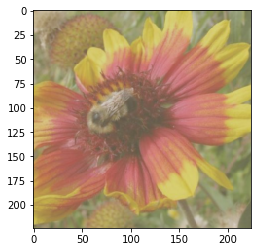

In [17]:
test_image = process_image(test_dir + '/100/image_07896.jpg')
imshow(test_image)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
def predict(image_path, my_model,topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    my_model.to('cpu') 
    my_model.eval()
    pic = process_image(image_path) 
    pic = torch.from_numpy(pic).type(torch.FloatTensor) 
    pic = pic.unsqueeze_(0) 
    
    
    with torch.no_grad():
        log_out = my_model.forward(pic)
        prob = torch.exp(log_out)
        top_predicted, top_class = prob.topk(topk) 
        np_top_class = np.array(top_class)
        
        idx_to_class = {val: key for key, val in my_model.class_to_idx.items()}
        top_predicted = np.array(top_predicted)[0] 
        top_class = np.array(top_class)[0]
        top_class = [idx_to_class[i] for i in top_class] 
        top_flowers = [cat_to_name[i] for i in top_class] 
    
    
    return top_predicted, top_class, top_flowers


In [19]:
predict("flowers/test/100/image_07896.jpg", my_model)

(array([ 0.49358749,  0.29436237,  0.13663319,  0.06429776,  0.00845733], dtype=float32),
 ['41', '54', '100', '5', '83'],
 ['barbeton daisy',
  'sunflower',
  'blanket flower',
  'english marigold',
  'hibiscus'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

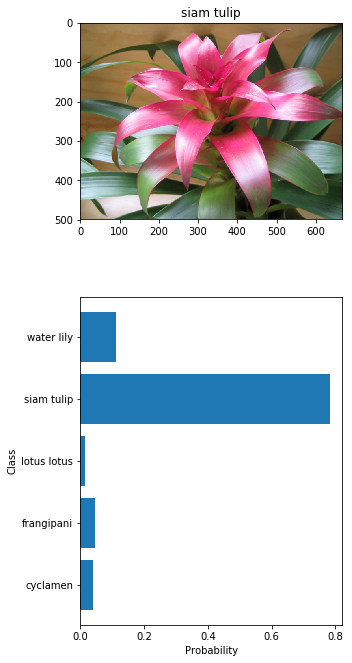

In [20]:

import matplotlib.pyplot as plt

def display(image_path, my_model):
    probability, top_classes, top_flowers = predict(image_path, my_model)
    
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    image = plt.imread(image_path)
    ax[0].imshow(image)
    ax[0].set_title(top_flowers[0])
    
    ax[1].barh(top_flowers, probability)
    ax[1].set_xlabel("Probability")
    ax[1].set_ylabel("Class")
    plt.tight_layout()
    plt.show()

display("flowers/test/99/image_07833.jpg", my_model)


<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [2]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace